In [1]:
# Imports, always include this at the beginning

# No science without NumPy
import numpy as np

# Matplotlib for plotting
import matplotlib.pyplot as plt
%matplotlib notebook

# Of course we want Glotaran
import glotaran as gta
# This things we just need for simulations, you can leave them out for fitting
from lmfit import Parameters

In [7]:
# First we define our model specification. See the documentation for details how to do so.
model_spec = '''
type: kinetic

parameters:
    - kinetic: [101e-1, 202e-3,505e-4]
    - shapes:
      - 1:
        - ["amp", 3, false]
        - ["loc", 620, false]
        - ["width", 10, false]
      - 2:
        - ["amp", 10, false]
        - ["loc", 670, false]
        - ["width", 30, false]
      - 3:
        - ["amp", 5, false]
        - ["loc", 720, false]
        - ["width", 50, false]
    - irf:
      - ["center", 0.5]
      - ["width", 5]


compartments: [s1, s2, s3]

megacomplexes:
    - label: mc1
      k_matrices: [k1]

k_matrices:
  - label: "k1"
    matrix: {
      '("s1","s1")': kinetic.1,
      '("s2","s2")': kinetic.2,
      '("s3","s3")': kinetic.3,
}       

shapes: 
  - label: gauss1
    type: gaussian
    amplitude: shapes.1.amp
    location: shapes.1.loc
    width: shapes.1.width
  - label: gauss2
    type: gaussian
    amplitude: shapes.2.amp
    location: shapes.2.loc
    width: shapes.2.width 
  - label: gauss3
    type: gaussian
    amplitude: shapes.3.amp
    location: shapes.3.loc
    width: shapes.3.width

irf: 
  - label: irf1
    type: gaussian
    center: irf.center
    width: irf.width 
    
initial_concentrations: []

datasets: 
  - label: dataset1
    type: spectral
    megacomplexes: [mc1]
    irf: irf1
    shapes:
      - [s1, gauss1]
      - [s2, gauss2]
      - [s3, gauss3]
'''

# Then we can create our model
model = gta.parse(model_spec)
print(model)

Modeltype: Kinetic

Parameter
---------
Label	Value	Min	Max	Fix
	<Parameter 'p_kinetic_1', 10.1, bounds=[-inf:inf]>
	<Parameter 'p_kinetic_2', 0.202, bounds=[-inf:inf]>
	<Parameter 'p_kinetic_3', 0.0505, bounds=[-inf:inf]>
	<Parameter 'p_shapes_1_amp', 3.0, bounds=[-inf:inf]>
	<Parameter 'p_shapes_1_loc', 620.0, bounds=[-inf:inf]>
	<Parameter 'p_shapes_1_width', 10.0, bounds=[-inf:inf]>
	<Parameter 'p_shapes_2_amp', 10.0, bounds=[-inf:inf]>
	<Parameter 'p_shapes_2_loc', 670.0, bounds=[-inf:inf]>
	<Parameter 'p_shapes_2_width', 30.0, bounds=[-inf:inf]>
	<Parameter 'p_shapes_3_amp', 5.0, bounds=[-inf:inf]>
	<Parameter 'p_shapes_3_loc', 720.0, bounds=[-inf:inf]>
	<Parameter 'p_shapes_3_width', 50.0, bounds=[-inf:inf]>
	<Parameter 'p_irf_center', 0.5, bounds=[-inf:inf]>
	<Parameter 'p_irf_width', 5.0, bounds=[-inf:inf]>


Compartments
-------------------------

['s1', 's2', 's3']

Megacomplexes
-------------

Label: mc1
K-Matrices: ['k1']

Datasets
--------

Dataset 'dataset1'

	Dataset Sc

In [8]:
# Now let us define some simulation parameters
sim_params = {
    "kinetic.1": 101e-3,
    "kinetic.2": 202e-4,
    "kinetic.3": 505e-5,
}

# We also need a spectral, a time axis and some amplitudes
spectral_axis = np.arange(600, 750, 1)
time_axis = np.arange(-10, 150, 1.5)
amplitudes = [1,0.1,7]

# Now we can simulate the data
model.simulate('dataset1', {"spectral": spectral_axis, "time": time_axis}, parameter=sim_params, noise=True, noise_std_dev=0.01)

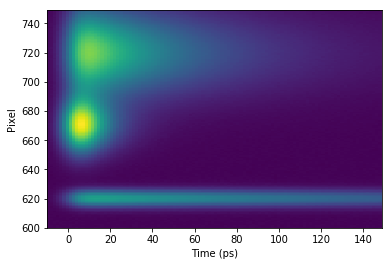

In [9]:
# Plot the simulated data

dataset = model.get_dataset("dataset1")
data = dataset.get()

fig = plt.figure()
plt.xlabel('Time (ps)')
plt.ylabel('Pixel')
plt.pcolormesh(time_axis, spectral_axis, data)
plt.show()

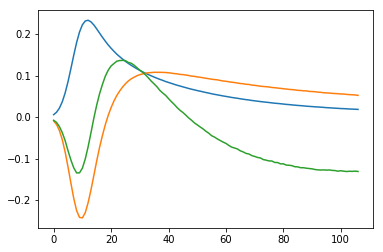

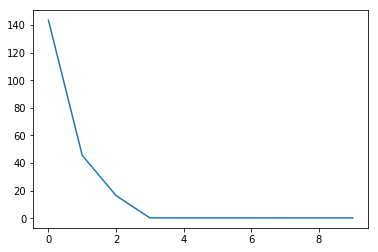

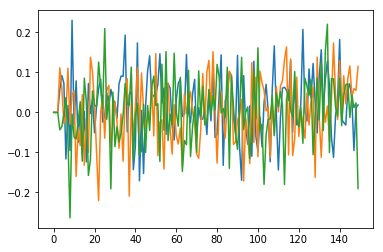

((150, 107), (107, 107), (150, 150))

In [10]:
# Plot the SVD

lsvd, svals, rsvd = dataset.svd()

nr_components = 3

fig = plt.figure()
plt.plot(lsvd[:,0:nr_components])
plt.show()
fig = plt.figure()
plt.plot(svals[0:10])
plt.show()
fig = plt.figure()
plt.plot(rsvd[:,0:nr_components])
plt.show()
(data.shape, lsvd.shape, rsvd.shape)

In [11]:
result = model.fit()
result.best_fit_parameter.pretty_print()

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.3983e+03                                    3.44e+04    
       1              3         1.1375e+03      2.61e+02       2.82e+00       1.38e+05    
       2              5         8.2243e+02      3.15e+02       7.05e-01       6.04e+04    
       3              6         3.9202e+02      4.30e+02       7.05e-01       1.62e+04    
       4              7         1.4316e+02      2.49e+02       1.41e+00       4.84e+03    
       5              8         3.4007e+01      1.09e+02       2.82e+00       5.61e+02    
       6             10         3.2080e+01      1.93e+00       1.41e+00       1.78e+02    
       7             11         3.2014e+01      6.66e-02       2.82e+00       1.32e+02    
       8             13         3.1805e+01      2.09e-01       7.05e-01       3.76e+01    
       9             15         3.1755e+01      4.99e-02       3.53e-01       1.97e+01    

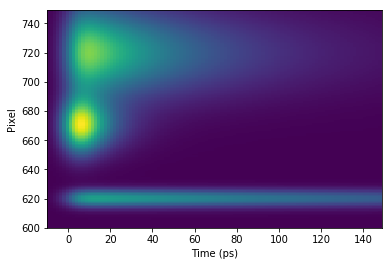

In [12]:
# Plot the fitted data

dataset = result.fitted_data('dataset1')
data = dataset.get()
fig = plt.figure()
plt.xlabel('Time (ps)')
plt.ylabel('Pixel')
plt.pcolormesh(time_axis, spectral_axis, data)
plt.show()

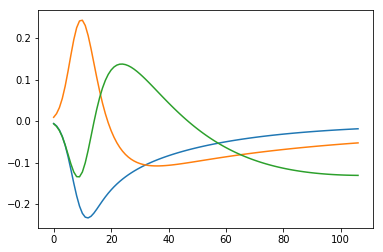

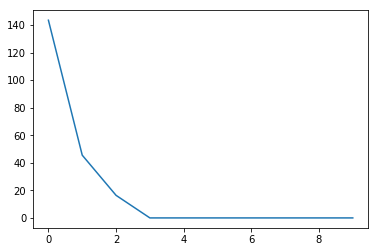

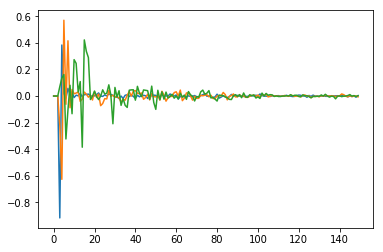

((150, 107), (107, 107), (150, 150))

In [13]:
# Plot the SVD

lsvd, svals, rsvd = dataset.svd()

nr_components = 3

fig = plt.figure()
plt.plot(lsvd[:,0:nr_components])
plt.show()
fig = plt.figure()
plt.plot(svals[0:10])
plt.show()
fig = plt.figure()
plt.plot(rsvd[:,0:nr_components])
plt.show()
(data.shape, lsvd.shape, rsvd.shape)